## 1. Model Selection

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Part 1

#### Useful Functions

In [3]:
def makePoly(x: float, p: int):
    row = np.array([])
    for i in range(0, p + 1):
        row = np.append(row, x**i)
    return row

#### Solution

Training MSE 		6.4750704463
Validation MSE 		1428.2361374214


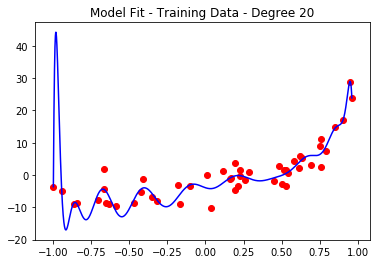

In [4]:
# Load data
train = np.genfromtxt('./data/Dataset_1_train.csv', delimiter=',', usecols=(0, 1))
valid = np.genfromtxt('./data/Dataset_1_valid.csv', delimiter=',', usecols=(0, 1))


# Create sets
N = len(train)
P = 20
train_input = train[:, 0]
train_target = train[:, 1]
valid_input = valid[:, 0]
valid_target = valid[:, 1]

# Create X and Y
X = np.array([])
for x in train_input:
    X = np.append(X, makePoly(x, P))
X = X.reshape(N, P + 1)
Y = train_target.reshape(-1, 1)

# Calculate coefficients
W = np.linalg.inv((X.T.dot(X))).dot((X.T.dot(Y)))

# Prepare points for plot
xx = np.linspace(min(train_input), max(train_input), N * 100)
yy = np.array([])

for i in range(0, N * 100):
    row = makePoly(xx[i], P)
    yy = np.append(yy, W.T.dot(row))

# Mean Squared Error calculation - Train set
mse_train = 0.0
for i in range(0, N):
    row = makePoly(train_input[i], P)
    y_model = W.T.dot(row)
    mse_train += (y_model - train_target[i]) ** 2
mse_train /= N
print('Training MSE \t\t%.10f' % mse_train)

# Mean Squared Error calculation - Validation set
mse_valid = 0.0
for i in range(0, N):
    row = makePoly(valid_input[i], P)
    y_model = W.T.dot(row)
    mse_valid += (y_model - valid_target[i]) ** 2
mse_valid /= N
print('Validation MSE \t\t%.10f' % mse_valid)

# Graph 
plt.figure(1)
plt.plot(xx, yy, color='b')
plt.scatter(train_input, train_target, color='r')
plt.title('Model Fit - Training Data - Degree 20')
plt.show()

#### Comments
Looking at the curve it seems like there is some **overfitting** due to the fact that between the first two points, on the the left, it seems like there's quite a high jump in value which does not fit the trend that the data's original model has.

### Part 2

#### Useful Functions

In [5]:
def calcW(x: np.ndarray, y: np.ndarray, degree: int, lamb=0):
    i = np.identity(degree + 1)
    w = np.linalg.inv((x.T.dot(x)) + (lamb * i)).dot((x.T.dot(y)))
    return w

def calcXY(data_set, degree: int):
    X = np.array([])
    Y = np.array(data_set[:, 1]).reshape(-1, 1)
    for data_point in data_set[:, 0]:
        X = np.append(X, makePoly(data_point, degree))
    X = X.reshape(len(data_set), degree + 1)
    return X, Y

def calcMSE(coeffs: np.ndarray, data_x: np.ndarray, data_y: np.ndarray,
            degree: int, count=-1):
    if count == -1:
        count = len(data_x)
    mse = 0
    for i in range(0, count):
        row = makePoly(data_x[i], degree)
        result = coeffs.T.dot(row)
        mse += ((result - data_y[i]) ** 2)
    mse /= count
    return mse

#### Solution

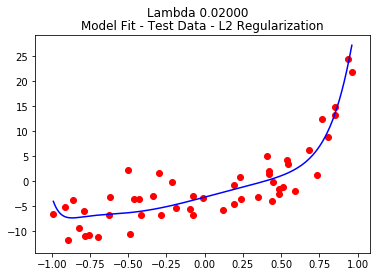

In [6]:
# Load data
train = np.genfromtxt('./data/Dataset_1_train.csv', delimiter=',', usecols=(0, 1))
valid = np.genfromtxt('./data/Dataset_1_valid.csv', delimiter=',', usecols=(0, 1))
test = np.genfromtxt('./data/Dataset_1_test.csv', delimiter=',', usecols=(0, 1))

# Create Sets
N = len(train)
P = 20
train_x = train[:, 0]
train_y = train[:, 1]
valid_x = valid[:, 0]
valid_y = valid[:, 1]
test_x = test[:, 0]
test_y = test[:, 1]

# Calculate X and Y
X, Y = calcXY(train, P)

# Calculate W
W = calcW(X, Y, P)

# Add L2 Regularization
lamb = 0
lambs = np.array([lamb])
mse_train = np.array([calcMSE(W, train_x, train_y, P, N)])
mse_validation = np.array([calcMSE(W, valid_x, valid_y, P, N)])

# Calculate W for all lambda between 0-1; Step size = 0.001
while lamb <= 1:
    lamb += 0.001
    lambs = np.append(lambs, lamb)
    w_new = calcW(X, Y, P, lamb)
    mse_train = np.append(mse_train, calcMSE(w_new, train_x, train_y, P, N))
    mse_validation = np.append(mse_validation, calcMSE(w_new, valid_x, valid_y, P, N))
    
# Put all the calculated mse's and lambdas in a table
mse = np.array([lambs, mse_train, mse_validation]).T

# Find the row in the table where validation mse is minimum
min_mse_valid_index = np.where(mse_validation == min(mse_validation))

# Record the lambda of that row
bestLambda = mse[min_mse_valid_index, 0][0][0]

# Calculate the new best vector of coefficients
minW = calcW(X, Y, P, bestLambda)

# Prepare points for plot
xx = np.linspace(min(test_x), max(test_x), N * 100)
yy = np.array([])

# Calculate our results for test data's x points
for i in range(0, N * 100):
    row = makePoly(xx[i], P)
    yy = np.append(yy, minW.T.dot(row))
    
# Plot our results against test data's y points
plt.figure(2)
plt.plot(xx, yy, color='b')
plt.scatter(test_x, test_y, color='r')
plt.title('Model Fit - Test Data - L2 Regularization')
plt.suptitle('Lambda %.5f' % bestLambda)
plt.show()

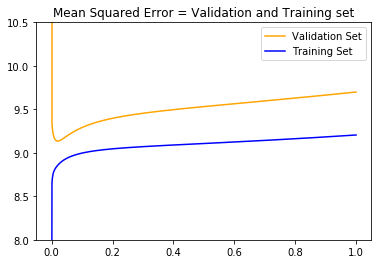

In [17]:
# Plot the validation and test MSE against different values of lambda
plt.figure(3)
mse_valid_plt, = plt.plot(lambs, mse_validation, color='orange')
mse_train_plt, = plt.plot(lambs, mse_train, color='blue')
plt.legend([mse_valid_plt, mse_train_plt], ['Validation Set', 'Training Set'])
plt.title('Mean Squared Error - Validation and Training set')
plt.ylim(8, 10.5)
plt.show()

#### Comments
The curve has smoothened a lot with the L2 regularization added. There no longer is a sudden unrealistic jump on the left and it seems like the curve is nicely fitting an averge line between the data at any point. Looking at the performance against the test data, this seems like a much better fit.

### Part 3
From the curve it seems to me that this is an even degree polynomial, as the value on the `y` axis seems to converge to the same value as `x` converges to both positive and negative infinity. However, as of the particular degree it seems like a 4 or 6 degree to me but since I tested the performance and achieved best results with a 6 degree polynomial, I assume the original model for the data is a 6 degree.